In [1]:
#импорт библиотек
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn.model_selection import train_test_split #сплитование выборки

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
import hyperopt
from hyperopt import hp, fmin, tpe, Trials
import optuna

In [2]:
data = pd.read_csv('data/_train_sem09.csv')
data.head()

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:xlabel='Activity', ylabel='count'>

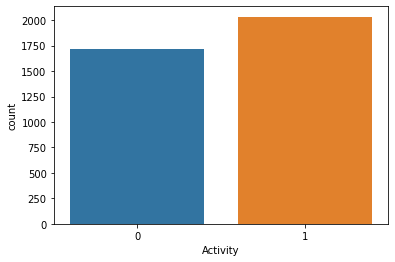

In [3]:
sns.countplot(data=data, x='Activity')

In [4]:
X = data.drop(['Activity'], axis=1)
y = data['Activity']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 1, test_size = 0.2)

### 1.) Логистическая регрессия

In [88]:
# Создаем и обучаем логистическую регрессию без подбора гиперпараметров
log_reg = linear_model.LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train, y_train)
y_test_pred = log_reg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.78


In [90]:
# GridSearchCV

param_grid = [
              {'penalty': ['l2', 'none'] ,
              'solver': ['lbfgs', 'sag'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]},
              
              {'penalty': ['l1', 'l2'] ,
              'solver': ['liblinear', 'saga'],
               'C': [0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 1]}
]
grid_search_lg = GridSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=8000), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_lg.fit(X_train, y_train) 

y_test_pred = grid_search_lg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_lg.best_params_))


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting

CPU times: user 573 ms, sys: 164 ms, total: 737 ms
Wall time: 14min 48s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}


Удалось улучшить целевую метрику с 0.78 до 0.79

In [91]:
# RandomizedSearchCV

param_grid = {'penalty': ['l2', 'none'],
              'solver': ['lbfgs', 'sag'],
               'C': list(np.linspace(0.01, 1, 10, dtype=float))},
            
random_search_lg = RandomizedSearchCV(
    estimator=linear_model.LogisticRegression(random_state=42, max_iter=8000), 
    param_distributions=param_grid, 
    cv=5, 
    n_iter = 30, 
    n_jobs = -1
)  
%time random_search_lg.fit(X_train, y_train) 
y_test_pred = random_search_lg.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_lg.best_params_))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting

CPU times: user 7.77 s, sys: 113 ms, total: 7.89 s
Wall time: 13min 25s
f1_score на тестовом наборе: 0.79
Наилучшие значения гиперпараметров: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.12}


Целевую метрику удалось увеличить до 0.79

In [106]:
# Hyperopt

space={'penalty': hp.choice('penalty', ['l2', 'none']),
       'solver' : hp.choice('solver', ['saga', 'sag', 'lbfgs'])
      }  

In [107]:
random_state = 42
def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    params = {'penalty': params['penalty'], 
              'solver': params['solver']
              }
  
    model = linear_model.LogisticRegression(**params, random_state=42, max_iter=8000)

    # обучаем модель можно с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    # метрику необходимо минимизировать, поэтому ставим знак минус
    return -score

In [108]:
# начинаем подбор гиперпараметров
trials = Trials()

best=fmin(hyperopt_rf,
          space=space,
          algo=tpe.suggest,
          max_evals=30,
          trials=trials,
          rstate=np.random.RandomState(random_state)
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 30/30 [14:37<00:00, 29.26s/trial, best loss: -0.7700109914680013]
Наилучшие значения гиперпараметров {'penalty': 0, 'solver': 1}


In [110]:
# рассчитаем f1_score для тестовой выборки

model = linear_model.LogisticRegression(penalty='l2', solver='sag', random_state=42, max_iter=1000)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))

y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.89
f1_score на тестовом наборе: 0.78


In [96]:
# Optuna

def optuna_lr(trial):
  
  penalty = trial.suggest_categorical('penalty', ['l2', 'none'])
  solver = trial.suggest_categorical('solver', ['lbfgs', 'sag'])
  C = trial.suggest_float('C', 0.01, 1)
  
  model = linear_model.LogisticRegression(penalty=penalty,
                                          solver=solver,
                                          C=C,
                                          random_state=42,
                                          max_iter=8000)

  # обучаем модель можно с помощью кросс-валидации
  # применим  cross validation с тем же количеством фолдов
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [97]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="LogisticRegression", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_lr, n_trials=30)

[I 2022-07-13 17:36:34,153] A new study created in memory with name: LogisticRegression
[I 2022-07-13 17:36:44,962] Trial 0 finished with value: 0.7735180488205698 and parameters: {'penalty': 'l2', 'solver': 'sag', 'C': 0.5097668584423523}. Best is trial 0 with value: 0.7735180488205698.
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1113: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/

CPU times: user 326 ms, sys: 361 ms, total: 687 ms
Wall time: 8min 36s


In [98]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'penalty': 'l2', 'solver': 'sag', 'C': 0.017571954183916896}
f1_score на обучающем наборе: 0.78


In [99]:
# рассчитаем точность для тестовой выборки
model = linear_model.LogisticRegression(**study.best_params, random_state=42, max_iter=1000)
model.fit(X_train, y_train)
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на тестовом наборе: 0.79


Удалось улучшить целевую метрику до 0.79

### 2.) Случайный лес

In [58]:
# Создаем и обучаем случайный лес без подбора гиперпараметров
rf = ensemble.RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
print('Train: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = rf.predict(X_test)
print('Test: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Train: 1.00
Test: 0.81


In [59]:
# GridSearchCV

param_grid = {'n_estimators': list(range(100, 300, 30)),
              'min_samples_leaf': list(np.linspace(2, 10, 1, dtype=int)),
              'max_depth': list(np.linspace(20, 40, 5, dtype=int))
              }
            
grid_search_forest = GridSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_grid=param_grid, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train, y_train) 
y_train_pred = grid_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = grid_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))

CPU times: user 2.55 s, sys: 96.9 ms, total: 2.65 s
Wall time: 42.5 s
f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'max_depth': 25, 'min_samples_leaf': 2, 'n_estimators': 280}


Целевая метрика улучшена до 0.82

In [60]:
# RandomizedSearchCV

param_grid = {'n_estimators': list(range(100, 300, 30)),
              'min_samples_leaf': list(np.linspace(2, 10, 1, dtype=int)),
              'max_depth': list(np.linspace(20, 40, 10, dtype=int))
              }
            
random_search_forest = RandomizedSearchCV(
    estimator=ensemble.RandomForestClassifier(random_state=42), 
    param_distributions=param_grid, 
    cv=5,
    n_iter = 20, 
    n_jobs = -1
)  
%time random_search_forest.fit(X_train, y_train) 
y_train_pred = random_search_forest.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = random_search_forest.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(random_search_forest.best_params_))

CPU times: user 2.37 s, sys: 68.5 ms, total: 2.44 s
Wall time: 26 s
f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.82
Наилучшие значения гиперпараметров: {'n_estimators': 280, 'min_samples_leaf': 2, 'max_depth': 40}


Целевая метрика улучшена до 0.82. Время, затраченное на рассчеты, меньше в 2 раза чем GridSearchCV

In [61]:
# Hyperopt

space={'n_estimators': hp.quniform('n_estimators', 100, 300, 30),
       'max_depth' : hp.quniform('max_depth', 20, 40, 10),
       'min_samples_leaf': hp.quniform('min_samples_leaf', 2, 10, 1)
      }

In [62]:
random_state = 42

def hyperopt_rf(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    params = {'n_estimators': int(params['n_estimators']), 
              'max_depth': int(params['max_depth']), 
             'min_samples_leaf': int(params['min_samples_leaf'])
              }
  
    model = ensemble.RandomForestClassifier(**params, random_state=random_state)
    
    # обучаем модель с помощью кросс-валидации
    # применим  cross validation с тем же количеством фолдов
    score = cross_val_score(model, X, y, cv=cv, scoring="f1", n_jobs=-1).mean()

    return -score

In [69]:
%%time
# подбор гиперпараметров

trials = Trials()

best=fmin(hyperopt_rf,
          space=space,
          algo=tpe.suggest,
          max_evals=20,
          trials=trials,
          rstate=np.random.RandomState(random_state)
         )
print("Наилучшие значения гиперпараметров {}".format(best))

100%|██████████| 20/20 [00:29<00:00,  1.46s/trial, best loss: -0.8150184544844586]
Наилучшие значения гиперпараметров {'max_depth': 40.0, 'min_samples_leaf': 2.0, 'n_estimators': 210.0}
CPU times: user 181 ms, sys: 227 ms, total: 408 ms
Wall time: 29.3 s


In [68]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(
    random_state=random_state, 
    n_estimators=int(best['n_estimators']),
    max_depth=int(best['max_depth']),
    min_samples_leaf=int(best['min_samples_leaf'])
)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.82


Целевая метрика улучшена до 0.82. Время, затраченное на рассчеты, меньше чем у GridSearchCV

In [72]:
# Optuna

def optuna_rf(trial):
  
  n_estimators = trial.suggest_int('n_estimators', 100, 310, 30)
  max_depth = trial.suggest_int('max_depth', 20, 40, 10)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель с помощью кросс-валидации
  # применим  cross validation с тем же количеством фолдов
  score = cross_val_score(model, X_train, y_train, cv=5, scoring="f1", n_jobs=-1).mean()

  return score

In [76]:
%%time
# cоздаем объект исследования
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

[I 2022-07-13 16:16:14,239] A new study created in memory with name: RandomForestClassifier
[I 2022-07-13 16:16:15,566] Trial 0 finished with value: 0.8009979345863375 and parameters: {'n_estimators': 190, 'max_depth': 30, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.8009979345863375.
[I 2022-07-13 16:16:17,094] Trial 1 finished with value: 0.8028350305365077 and parameters: {'n_estimators': 220, 'max_depth': 30, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.8028350305365077.
[I 2022-07-13 16:16:18,113] Trial 2 finished with value: 0.8026617870061544 and parameters: {'n_estimators': 130, 'max_depth': 20, 'min_samples_leaf': 4}. Best is trial 1 with value: 0.8028350305365077.
[I 2022-07-13 16:16:18,898] Trial 3 finished with value: 0.7961070837911264 and parameters: {'n_estimators': 100, 'max_depth': 30, 'min_samples_leaf': 9}. Best is trial 1 with value: 0.8028350305365077.
[I 2022-07-13 16:16:20,019] Trial 4 finished with value: 0.8062244173695184 and parameters: {'n_

CPU times: user 211 ms, sys: 236 ms, total: 447 ms
Wall time: 31.8 s


In [77]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 250, 'max_depth': 40, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.81


In [78]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
print('f1_score на обучающем наборе: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
y_test_pred = model.predict(X_test)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

f1_score на обучающем наборе: 0.99
f1_score на тестовом наборе: 0.82


Целевая метрика улучшена до 0.82. Время, затраченное на рассчеты, меньше чем GridSeachCV